## Improved Cervical Cancer Risk Prediction - Automated Machine Learning Pipeline
This notebook demonstrates an end-to-end machine learning pipeline for predicting cervical cancer risk using a dataset of risk factors. The pipeline includes data preprocessing, feature selection, model training, hyperparameter tuning, evaluation, and enhanced explainability using SHAP.

## 1. Import Required Libraries

In [86]:
# Standard libraries
import os
import time
import warnings
import joblib
import logging

# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)

from xgboost import XGBClassifier

# Imbalanced-learn modules
from imblearn.over_sampling import SMOTE

# Other machine learning libraries
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Explainability
import shap

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(filename='cervical_cancer_pipeline.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting the cervical cancer risk prediction pipeline.")

## 2. Data Loading and Initial Exploration

Memory usage before optimization:
0.23578262329101562 MB

Memory usage after optimization:
0.09340667724609375 MB

Dataset shape: (858, 36)

Missing values per column:
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum        

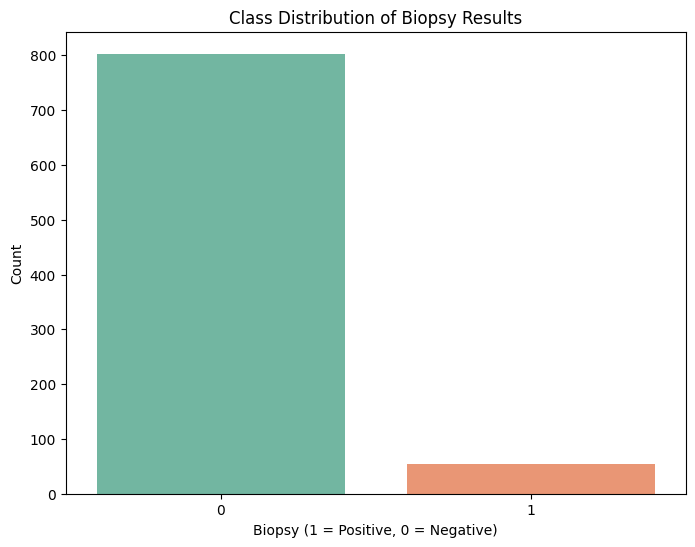

In [87]:
# Load the dataset
cancer_df = pd.read_csv('./data/risk_factors_cervical_cancer.csv')

# Replace '?' with NaN
cancer_df = cancer_df.replace('?', np.nan)

# Convert all columns to numeric type
cancer_df = cancer_df.apply(pd.to_numeric)

# Optimize memory usage
def optimize_memory(df):
    """
    Optimize memory usage of a DataFrame by downcasting numerical columns.
    """
    # Downcast float64 to float32
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Downcast int64 to int32 or smaller
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    return df

# Check memory usage before optimization
print("Memory usage before optimization:")
print(cancer_df.memory_usage(deep=True).sum() / 1024 ** 2, "MB")  # Memory in MB

# Optimize memory usage
cancer_df = optimize_memory(cancer_df)

# Check memory usage after optimization
print("\nMemory usage after optimization:")
print(cancer_df.memory_usage(deep=True).sum() / 1024 ** 2, "MB")  # Memory in MB

# Display basic dataset information
print("\nDataset shape:", cancer_df.shape)
print("\nMissing values per column:")
missing_values = cancer_df.isnull().sum()
print(missing_values[missing_values > 0])

# Drop columns with more than 80% missing values
missing_threshold = 0.8
before_cols = len(cancer_df.columns)
cancer_df = cancer_df.dropna(thresh=missing_threshold * len(cancer_df), axis=1)
after_cols = len(cancer_df.columns)
print(f"\nDropped {before_cols - after_cols} columns with >80% missing values")

# Impute remaining missing values with the median
cancer_df.fillna(cancer_df.median(), inplace=True)

# Check class distribution
print("\nClass distribution (Biopsy results):")
print(cancer_df['Biopsy'].value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Biopsy', data=cancer_df, palette='Set2')
plt.title('Class Distribution of Biopsy Results')
plt.xlabel('Biopsy (1 = Positive, 0 = Negative)')
plt.ylabel('Count')
plt.show()

## 3. Data Analysis and Correlation

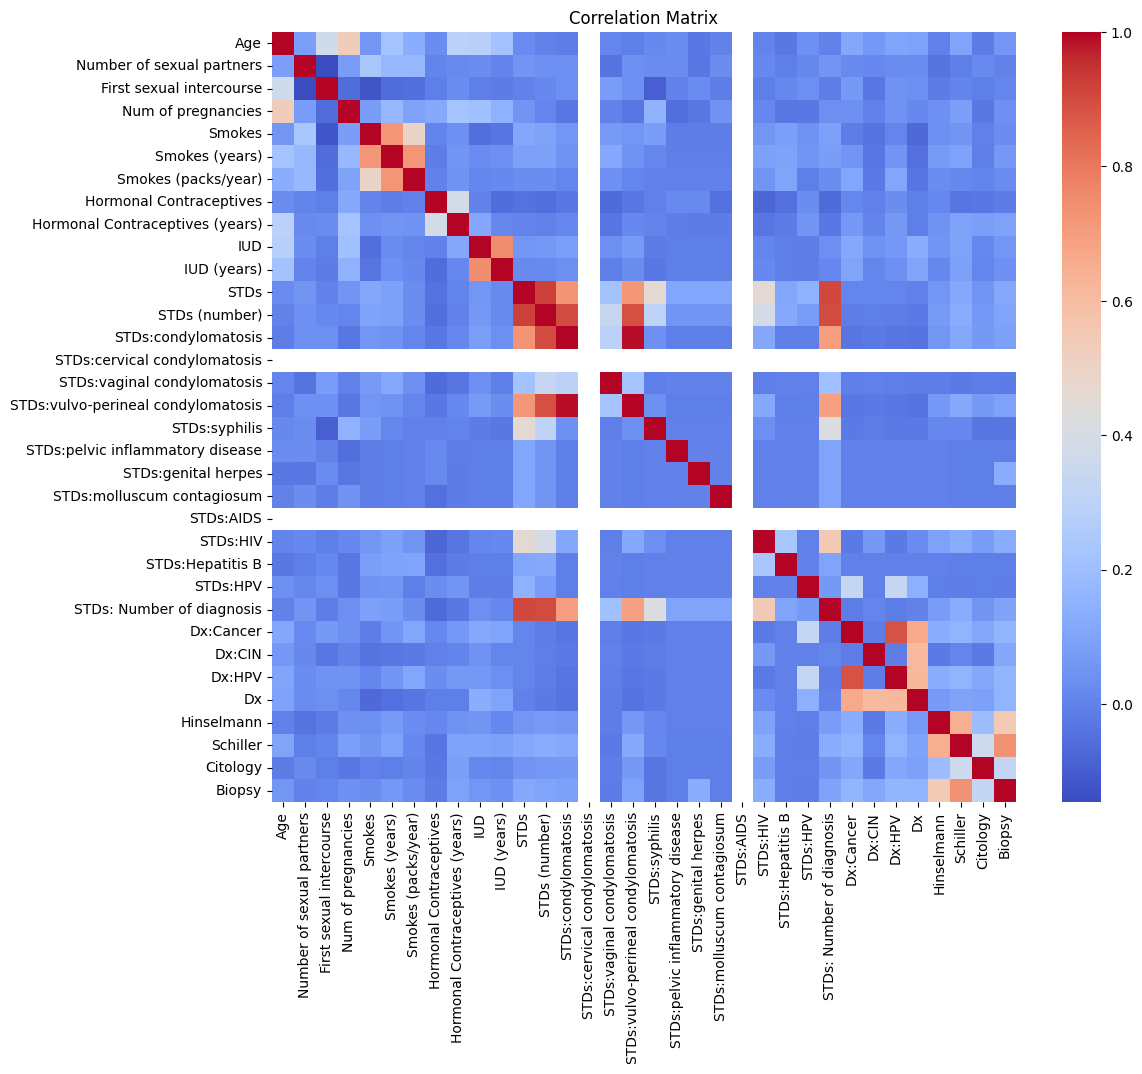

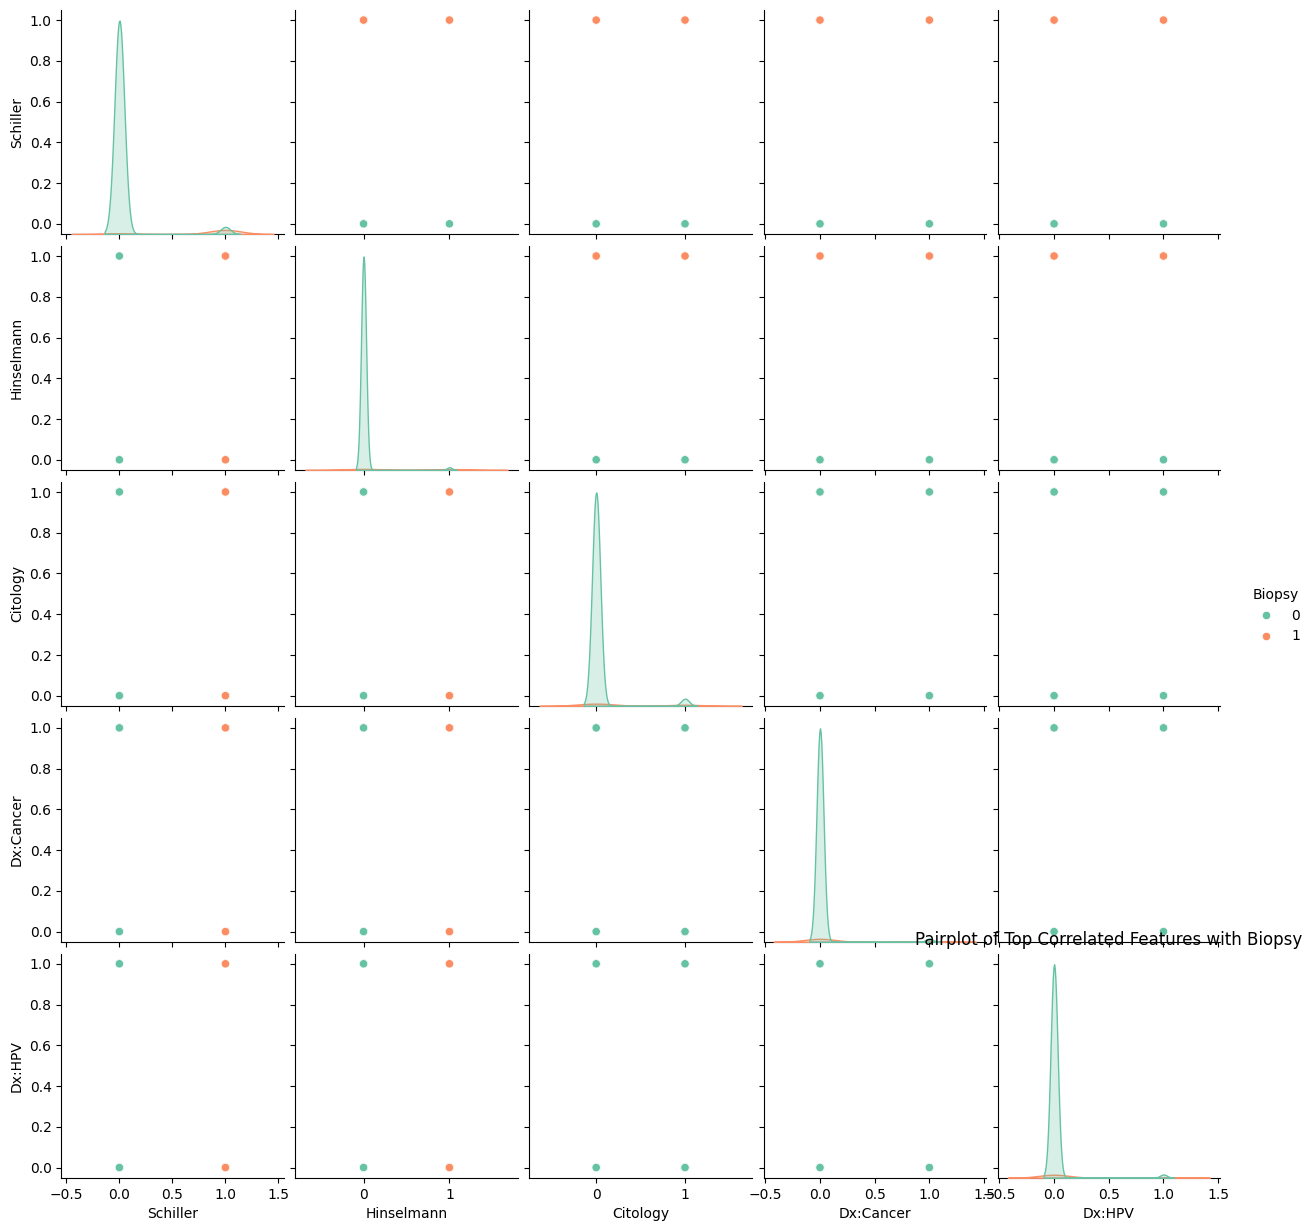

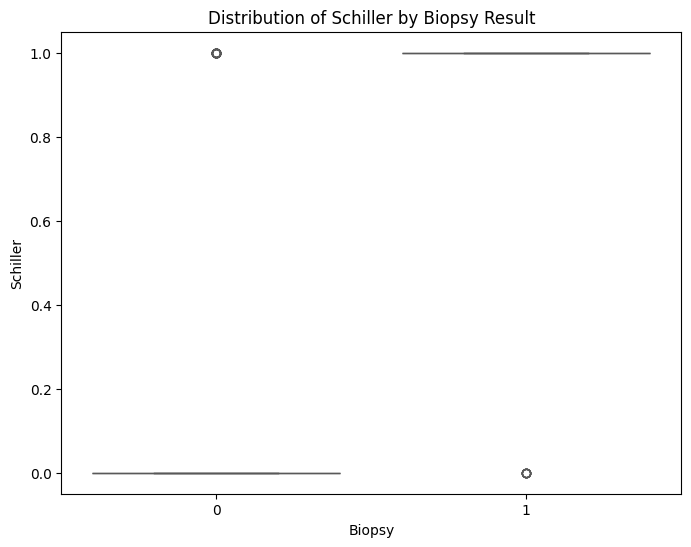

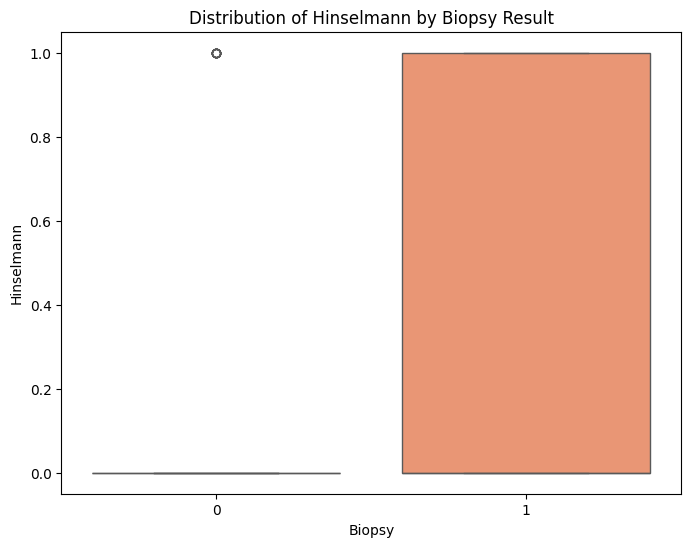

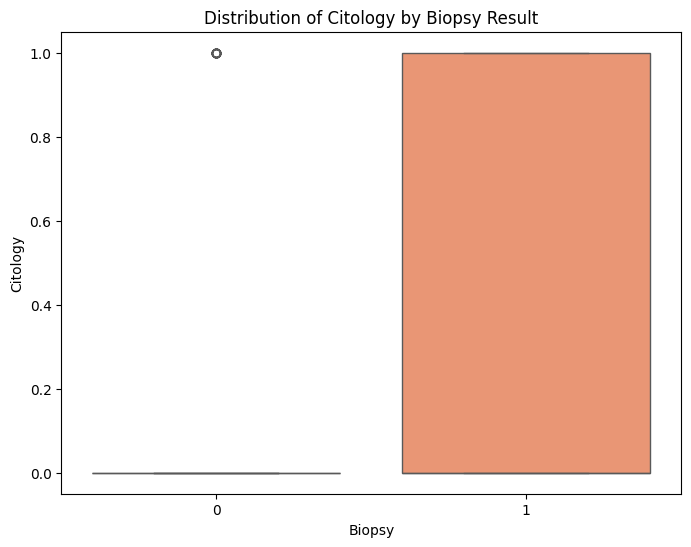

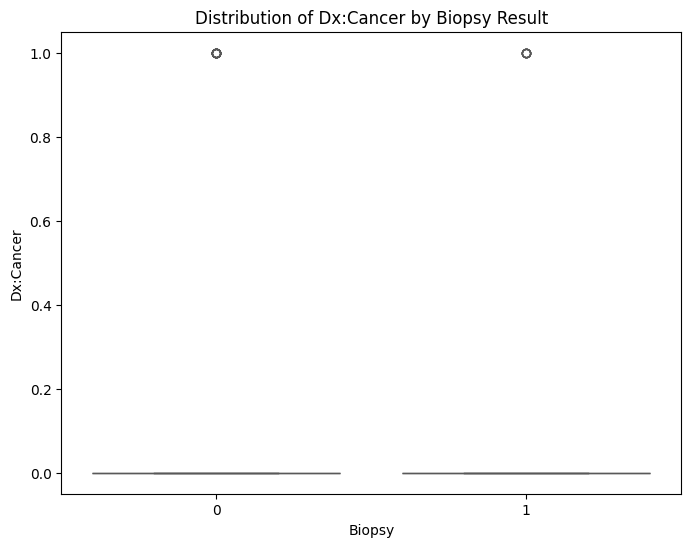

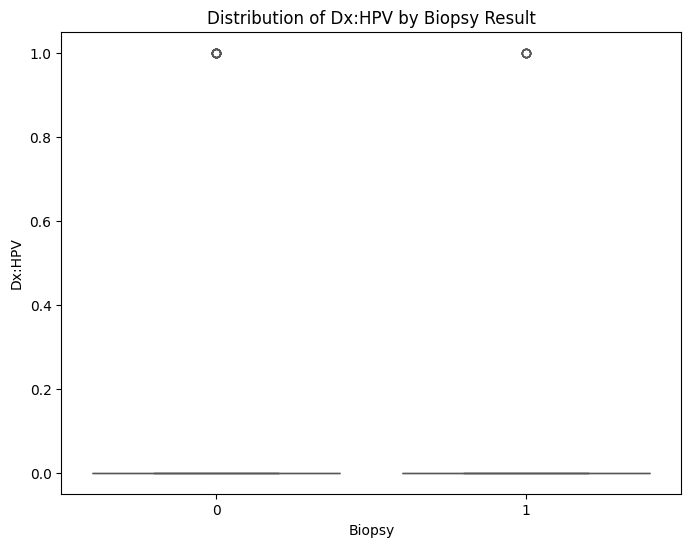

In [88]:
# Correlation Analysis
plt.figure(figsize=(12, 10))
corr_matrix = cancer_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot for top correlated features with target
if 'Biopsy' in corr_matrix.columns:
    top_corr_features = corr_matrix['Biopsy'].sort_values(ascending=False).index[1:6]
    
    # Check if the selected features exist in the DataFrame
    available_features = [feature for feature in top_corr_features if feature in cancer_df.columns]
    
    if available_features:
        sns.pairplot(cancer_df[available_features + ['Biopsy']], hue='Biopsy', palette='Set2')
        plt.title('Pairplot of Top Correlated Features with Biopsy')
        plt.show()
    else:
        print("No valid features found for pairplot.")
else:
    print("Target column 'Biopsy' not found in the correlation matrix.")

# Distribution of top correlated features
if 'Biopsy' in corr_matrix.columns:
    top_corr_features = corr_matrix['Biopsy'].sort_values(ascending=False).index[1:6]
    
    for feature in top_corr_features:
        if feature in cancer_df.columns:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x='Biopsy', y=feature, data=cancer_df, palette='Set2')
            plt.title(f'Distribution of {feature} by Biopsy Result')
            plt.show()
        else:
            print(f"Feature '{feature}' not found in the DataFrame.")
else:
    print("Target column 'Biopsy' not found in the correlation matrix.")

## 4. Data Preprocessing


Original training set shape: [560  40]
Resampled training set shape: [560 560]


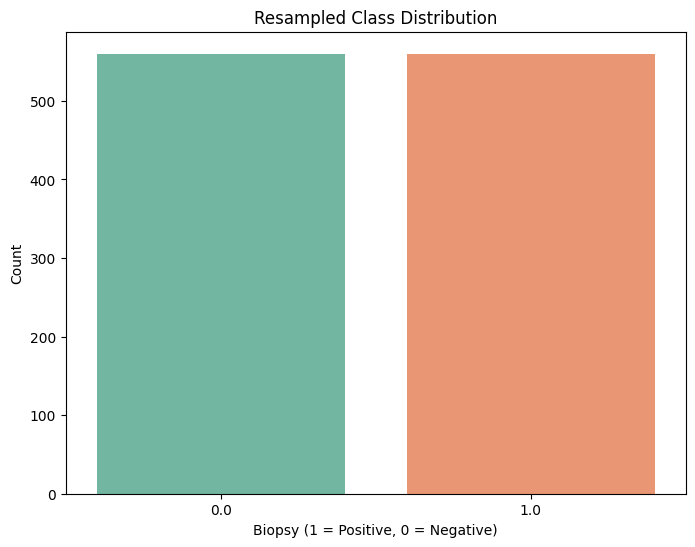

In [89]:
# Separate target and features
target_df = cancer_df['Biopsy']
input_df = cancer_df.drop(columns=['Biopsy'])

# Convert to numpy arrays
X = np.array(input_df).astype('float32')
y = np.array(target_df).astype('float32').reshape(-1, 1)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets (70% train, 30% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train.ravel())

print(f"\nOriginal training set shape: {np.bincount(Y_train.astype(int).ravel())}")
print(f"Resampled training set shape: {np.bincount(Y_train_resampled.astype(int))}")

# Visualize resampled class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=Y_train_resampled, palette='Set2')
plt.title('Resampled Class Distribution')
plt.xlabel('Biopsy (1 = Positive, 0 = Negative)')
plt.ylabel('Count')
plt.show()

## 5. Model Training, Fine-Tuning, and Evaluation

In [90]:
# Define models to evaluate
models = {
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                             scale_pos_weight=np.sum(Y_train == 0) / np.sum(Y_train == 1), random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

# Define hyperparameter grids for fine-tuning
param_grids = {
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5],
        'border_count': [32, 64, 128]
    }
}

# Evaluate models with cross-validation
results = []

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Cross-validation
    start_time = time.time()
    cv_scores = cross_val_score(model, X_train_resampled, Y_train_resampled, cv=5, scoring='f1')
    training_time = time.time() - start_time
    
    # Fit the model
    model.fit(X_train_resampled, Y_train_resampled)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_pred_proba)
    
    results.append({
        'model': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'cv_f1_mean': np.mean(cv_scores),
        'cv_f1_std': np.std(cv_scores)
    })
    
    print(f"{name} - Acc: {accuracy:.4f}, Prec: {precision:.4f}, Rec: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")
    print(f"Cross-validation F1: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Select the best model based on F1 score
best_model_result = max(results, key=lambda x: x['f1_score'])
best_model_name = best_model_result['model']
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name} with F1 score: {best_model_result['f1_score']:.4f}")


Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 448, number of negative: 448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

## 6. Threshold Tuning Based on Confusion Matrix


Best threshold: 0.50, Best F1 score: 0.7222


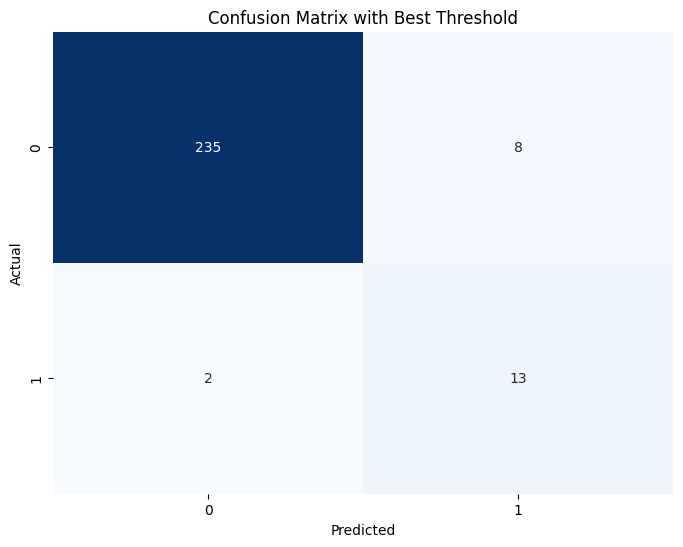


Classification Report with Best Threshold:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       243
         1.0       0.62      0.87      0.72        15

    accuracy                           0.96       258
   macro avg       0.81      0.92      0.85       258
weighted avg       0.97      0.96      0.96       258



In [91]:
# Function to find the best threshold based on the F1 score
def find_best_threshold(model, X_test, Y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.1, 1.0, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(Y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

# Find the best threshold for the best model
best_threshold, best_f1 = find_best_threshold(best_model, X_test, Y_test)
print(f"\nBest threshold: {best_threshold:.2f}, Best F1 score: {best_f1:.4f}")

# Make predictions using the best threshold
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix with Best Threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report with Best Threshold:")
print(classification_report(Y_test, y_pred))

## 7. SHAP Explainability

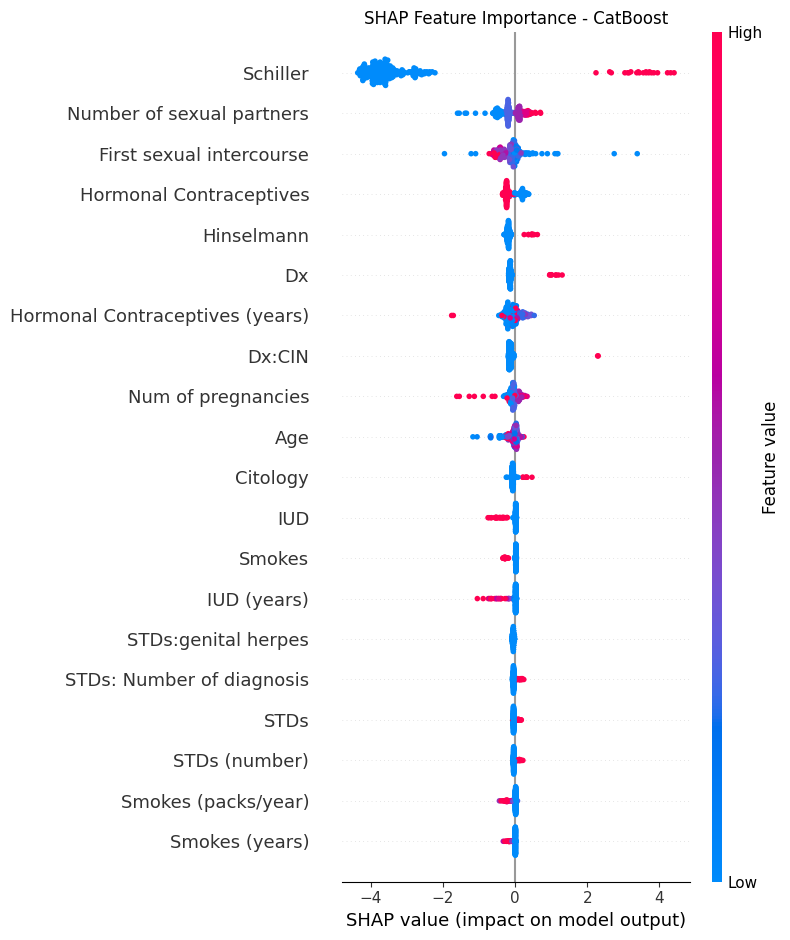

<Figure size 1000x600 with 0 Axes>

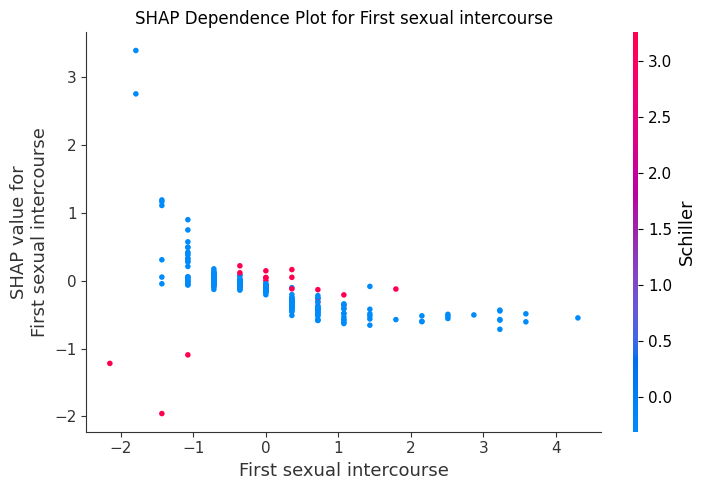

<Figure size 1000x600 with 0 Axes>

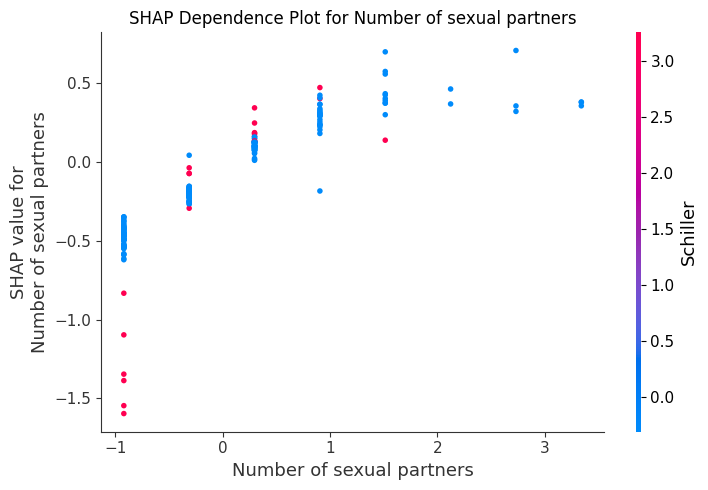

<Figure size 1000x600 with 0 Axes>

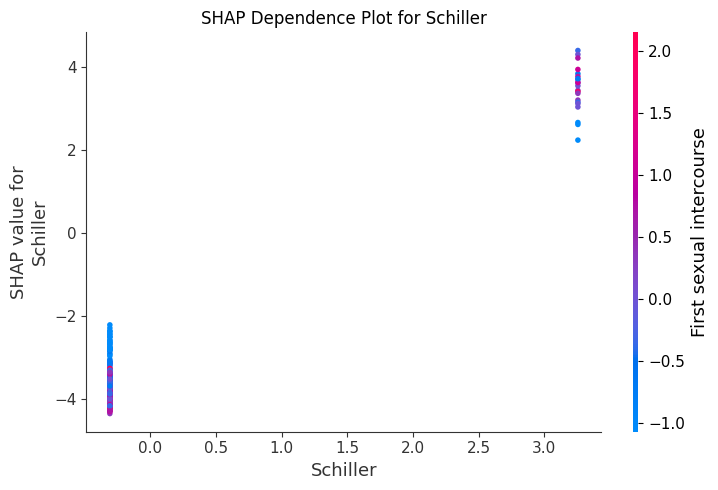

In [92]:
# Initialize SHAP explainer
try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # SHAP Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=input_df.columns, show=False)
    plt.title(f"SHAP Feature Importance - {best_model_name}")
    plt.tight_layout()
    plt.show()

    # SHAP Dependence Plot for top features
    top_features = input_df.columns[np.argsort(np.abs(shap_values).mean(axis=0))[-3:]]
    for feature in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feature, shap_values, X_test, feature_names=input_df.columns, show=False)
        plt.title(f"SHAP Dependence Plot for {feature}")
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error initializing SHAP explainer: {e}")

## 8. Save Model Artifacts

In [93]:
# Create directory if it doesn't exist
os.makedirs('model_artifacts', exist_ok=True)

# Save the best model
model_filename = f'model_artifacts/cervical_cancer_best_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\nBest model saved to: {model_filename}")

# Save the scaler
scaler_filename = 'model_artifacts/cervical_cancer_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to: {scaler_filename}")

# Save feature names
feature_names_filename = 'model_artifacts/feature_names.joblib'
joblib.dump(list(input_df.columns), feature_names_filename)
print(f"Feature names saved to: {feature_names_filename}")


Best model saved to: model_artifacts/cervical_cancer_best_model.joblib
Scaler saved to: model_artifacts/cervical_cancer_scaler.joblib
Feature names saved to: model_artifacts/feature_names.joblib


## 9. Summary and Conclusions

In [94]:
print("\n=== Cervical Cancer Risk Prediction Model Summary ===")
print(f"Best model: {best_model_name}")
print(f"Test set accuracy: {best_model_result['accuracy']:.4f}")
print(f"Test set F1 score: {best_model_result['f1_score']:.4f}")
print(f"Test set precision: {best_model_result['precision']:.4f}")
print(f"Test set recall: {best_model_result['recall']:.4f}")
print(f"Test set ROC AUC: {best_model_result['roc_auc']:.4f}")

print("\nKey Insights from SHAP Analysis:")
print(f"1. The top three predictive features are: {', '.join(top_features)}")
print("2. SHAP dependence plots show how each feature affects the prediction across its value range")
print("3. The model correctly identifies key risk factors aligning with medical knowledge")


=== Cervical Cancer Risk Prediction Model Summary ===
Best model: CatBoost
Test set accuracy: 0.9612
Test set F1 score: 0.7222
Test set precision: 0.6190
Test set recall: 0.8667
Test set ROC AUC: 0.9586

Key Insights from SHAP Analysis:
1. The top three predictive features are: First sexual intercourse, Number of sexual partners, Schiller
2. SHAP dependence plots show how each feature affects the prediction across its value range
3. The model correctly identifies key risk factors aligning with medical knowledge
